# Using Intelligence from Indeed Job postings to augment my skills.

## 1. Problem statement
I am confused on what skills are most relevant in the current job market. So after learning Ensemble learning, I loved the concept and thought of applying that idea to find my skills gap using ensemble of relevant skill data from the Indeed job posting. More like an wisdom of crowd approach. So I am aiming to find relevant skills that I should learn next before applying for my next Job to improve my odds of getting hired, and feel more confident.

## 2. Approach
First we will download data from Indeed. I made a web scraper https://github.com/rajdeepmondal1/indeed-job-scraper that scrapes the https://in.indeed.com/ website for our essential data after searching for Data Scientist, Data Engineer, Data Science Consultant, Data Analyst and Machine Learning Engineer. Since the lines are blurry about what a Data Scientist does, we scrape data about these adjacent titles to remove bias in our data. Indeed website offers millions of searchable job listings, posted by understaffed employers. It has a built-in search engine, which allows us to filter the jobs by keyword. We will download the required information and store it in separate html files for the job listings.

Our goal is to extract common data science and machine learning skills from the downloaded data. We’ll then compare these skills to our skills to determine which skills are missing. To reach our goal, we’ll proceed like this:
 - Parse out all the text from the downloaded HTML files.
 - Explore the parsed output to learn how job skills are commonly described in online postings. Perhaps specific HTML tags are more commonly used to underscore job skills.
 - Try to filter out any irrelevant job postings from our dataset. The search engine isn’t perfect. Perhaps some irrelevant postings were erroneously downloaded. We can evaluate relevance by comparing the postings with our skill list.
 - Cluster the job skills within the relevant postings, and visualize the clusters.
 - Make a plan to improve on the skills that are missing.

In [1]:
import zipfile

def unzip_data(filename):
  """
  Unzips filename into the current working directory.
  Args:
    filename (str): a filepath to a target zip folder to be unzipped.
  """
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [5]:
!git clone https://github.com/rajdeepmondal1/what-skills-to-augment-my-arsenal-main

Cloning into 'what-skills-to-augment-my-arsenal-main'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 1), reused 6 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [6]:
data_location = '/content/what-skills-to-augment-my-arsenal-main/data/data_2161_listings.zip'

In [7]:
unzip_data(data_location)

## 3. Dataset description
I have scraped a total of 2161 listings using https://github.com/rajdeepmondal1/indeed-job-scraper from https://in.indeed.com/ including -
 - Data Scientist with 735 listings
 - Machine Learning Engineer with 654 listings
 - Data Engineer with 317 listings
 - Data Science Consultant with 151 listings
 - Data Analyst with 304 listings
The title, company name, ratings and job description was scraped from the website for each listing.

Our rough draft of skills are stored in the skills.txt file.

We will proceed as follows:

1. Parse all text from the downloaded HTML files.
2. Explore the parsed output to learn how job skills are described in online postings. We’ll pay particular attention to whether certain HTML tags are more associated with skill descriptions.
3. Attempt to filter any irrelevant job postings from our dataset.
4. Cluster job skills based on text similarity.
5. Visualize the clusters using word clouds.
6. Adjust clustering parameters, if necessary, to improve the visualized output.
7. Compare the clustered skills to our resume to uncover missing skills.

## 4. Extracting skill requirements from job posting data

### 4.1. Loading HTML files

In [17]:
import glob

# Evading any warnings
import warnings
warnings.filterwarnings('ignore')

In [18]:
html_contents = []

for file_name in sorted(glob.glob('/content/data_2161_listings/*/*.html')):
    with open(file_name, encoding="utf8") as f:
        html_contents.append(f.read())
        
print(f"We've loaded {len(html_contents)} HTML files.")

We've loaded 2161 HTML files.


### 4.2. Parsing HTML files

In [19]:
# import beautiful soup
from bs4 import BeautifulSoup as bs

In [20]:
soup_objects = []

# parse through all the html file and store it in soup objects
for html in html_contents:
    soup = bs(html)
    soup_objects.append(soup)

### 4.3. Extracting Title, Company Name and Description into their own variables.

In [21]:
# import pandas
import pandas as pd

In [22]:
# dictionary to store values of title, company name and description
html_dict = {
    'title': [],
    'company_name': [],
    'description': []
    }

for soup in soup_objects:
    try:
        # try to get the title using the class tag 'jobsearch-JobInfoHeader-title'
        title = soup.findAll('h1', class_='jobsearch-JobInfoHeader-title')[0].text.strip()
    except:
        title = None  
        
    try:
        # try to get the company rating using the class tag 'jobsearch-InlineCompanyRating'
        company_temp = soup.findAll('div', class_='jobsearch-InlineCompanyRating')[0]
    except:
        pass
    
    try:
        # try to get the company name
        company_name = company_temp.findAll('a')[0].text.strip()
    except:
        company_name = None
        
    # .decompose() removes a tag from the tree, then completely destroys it and its contents
    soup.findAll('h1', class_='jobsearch-JobInfoHeader-title')[0].decompose()
    soup.findAll('div', class_='jobsearch-InlineCompanyRating')[0].decompose()
    # after the decompose function removes these elements we can take the rest as description
    description = soup.text.strip()
    html_dict['title'].append(title)
    html_dict['company_name'].append(company_name)
    html_dict['description'].append(description)
    
df_jobs = pd.DataFrame(html_dict)
df_jobs[['title', 'company_name']].describe()

,title,company_name
count,2161,1270
unique,979,404
top,Data Scientist,IBM
freq,204,37


There are 979 Unique Job Titles with Data Scientist being the most used title with a frequency of 204 and 404 Unique Company Names with the company with the most listings being IBM with 37 listings.

### 4.4. Checking for Null Values.

In [23]:
df_jobs['title'].isna().sum()

0

There are no null values in the title column, so we can proceed with our analysis as title is really important to analyze the job listings.

### 4.5. An Example Listing.

In [24]:
from IPython.core.display import display, HTML
display(HTML(html_contents[991]))

**This was a listing we extracted from the https://in.indeed.com/ website after searching for Data Scientist in India.**

The rendered job posting with a title, company name, location, brief position overview, responsibilities and quanifications. From this, we learn that the job entails surfacing insights from the data and provide strategic recommendations to better customize marketing efforts to the new region.

The skills are further elaborated in the two bolded subsections: Responsibilities, Basic Qualifications and Preferred Qualifications. Each subsection is composed of multiple single-sentence bullet points. The bullets are varied in their content but it’s worth noting that the qualifications are not that different from the responsibilities.

The qualifications focus on tools and concepts, while the responsibilities are more attuned to actions on the jobs; but in a way, their bullet points are interchangeable. Each bullet describes a skill that an applicant must have to perform well at the job. Thus, we can subdivide html_contents[0] into two conceptually different parts:

 - An initial job summary.
 - A list of bulleted skills required to get the job.

Now let us select another Random job posting to check if the Postings have a similar format.

In [26]:
display(HTML(html_contents[777]))

This job posting is for a Staff Data Scientist position at myntra.com in Bengaluru, Karnataka. The structure is similar to the previous posting. The job is summarized in the post’s initial paragraph, and then the required skills are presented in bullet points. These bulleted skills are varied in terms of technical requirements and details.

The bullet points in listing 991 and in listing 777 serve a singular purpose: they offer us brief, sentence-length descriptions of unique skills required for each position.

We will extract the bullets from each of our parsed HTML files to find out if the bullet skill descriptions appear in other job posts.

### 4.6. Extracting bullets from the HTML

In [27]:
# bullet.text.strip() Strips the line break from each bullet to avoid printing 
# the line breaks in our later investigations
df_jobs['Bullets'] = [[bullet.text.strip() for bullet in soup.find_all('li')] for soup in soup_objects]

The bullets in each job posting are stored in Bullets of the df_jobs dataframe. However, it is possible that some of the postings don’t include any bullets.

### 4.7. Measuring the percent of bulleted postings

In [28]:
bulleted_post_count = 0
for bullet_list in df_jobs['Bullets']:
    if bullet_list:
        bulleted_post_count += 1
percent_bulleted = 100 * bulleted_post_count / df_jobs.shape[0]
print(f"{percent_bulleted:.2f}% of the postings contain bullets")

86.12% of the postings contain bullets


To understand the contents of the bullet points we can print the top-ranked words in their text. We can rank these words by carrying out the ranking using term frequency inverse document frequency (TFIDF) values rather than raw counts. TFIDF rankings are less likely to contain irrelevant words.

Next, we rank the words using summed TFIDF values. First we compute a TFIDF matrix in which rows correspond to individual bullets. Then we sum across the rows of the matrix: these sums are used to rank the words, which correspond to matrix columns. Finally, we check the top five ranked words for skill-related terminology.

### 4.8. Examining the top-ranked words in the bullets.

In [29]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
def rank_words(text_list):
    """
      Returns a sorted Pandas table of top-ranked words
      args: text_list: input list of text
    """
    # initialize the tfidf vectorizer using stop words in english
    vectorizer = TfidfVectorizer(stop_words='english')
    # fit the vectorizer to the input text list and convert it to an array
    tfidf_matrix = vectorizer.fit_transform(text_list).toarray()
    # create a dataframe to store the words with their tfidf scores
    df = pd.DataFrame({'Words': vectorizer.get_feature_names(),
                       'Summed TFIDF': tfidf_matrix.sum(axis=0)})
    # sort the dataframe according to the tfidf scores
    sorted_df = df.sort_values('Summed TFIDF', ascending=False)
    return sorted_df

In [33]:
all_bullets = []

# store all the bullets in a list
for bullet_list in df_jobs['Bullets']:
    all_bullets.extend(bullet_list)

# rank all the words from the bullets
sorted_df = rank_words(all_bullets)
print(sorted_df[:5].to_string(index=False))

     Words  Summed TFIDF
      data   1268.549381
experience   1114.200969
  learning    585.266786
      work    565.704799
    skills    565.142082


Words like data, experience, learning, work and skills appear among the top five bulleted words. There’s reasonable evidence that the bullets correspond to individual job skills.

Next we will check how the bulleted words compare to the remaining words in each job posting by iterating over the body of each posting and delete any bulleted lists using Beautiful Soup’s decompose method. Then we extract the remaining body text and store it in a non_bullets list. Finally, we apply our rank_words function to that list and display the top five non-bullet words.

### 4.9. Examining the top-ranked words in the the description except the bullets.

In [35]:
non_bullets = []
for soup in soup_objects:
    body = soup.body
    for tag in body.find_all('li'):
        tag.decompose()
    non_bullets.append(body.text)
    
sorted_df = rank_words(non_bullets)
print(sorted_df[:5].to_string(index=False))

     Words  Summed TFIDF
      data    153.474594
experience     81.848449
       job     70.631671
      work     70.048442
    skills     63.047988


The non bulleted text seems to contain more of things like experiance, job, work, data and skills. These seem to be quite similar corrosponding to the bulleted materails.

Next we will check how the percentage of titles that has Data Scientist mentioned in their names.

### 4.10. Checking titles for references to data science positions.

In [36]:
from sklearn.utils import shuffle

In [37]:
regex = r'Data Scien(ce|tist)'
df_non_ds_jobs = df_jobs[~df_jobs.title.str.contains(regex, case=False)]

percent_non_ds = 100 * df_non_ds_jobs.shape[0] / df_jobs.shape[0]
print(f"{percent_non_ds:.2f}% of the job posting titles do not mention a data science position.")

68.90% of the job posting titles do not mention a data science position.


In [38]:
# Let's shuffle the df_non_ds_jobs DataFrame
df_non_ds_jobs = shuffle(df_non_ds_jobs)
df_non_ds_jobs.reset_index(inplace=True, drop=True)

print('These are the samples of such titles: - ')
for title in df_non_ds_jobs.title[:15]:
    print(title)

These are the samples of such titles: - 
Data Engineer - Azure
Engineer - CFD
Associate Data Engineer
Data Engineer
Associate Software Engineer
Senior Associate - Machine Learning Engineer
Engineer IIOT
Cloud Engineer in Machine Learning area
Sr. Machine Learning Engineer, SMAI
Solution Consultant - MDM
2A_Business Analyst Trainee_SQL
ETL Principal Software Engineer
Machine Learning Engineer (Remote)
Data Analyst (UK Pathways Admissions)
Quantitative Engineer - Eqs Sts Strats


68.90% of the job posting titles do not mention a data science position. However, from our sampled output, we can glean the alternative language that can be used to describe a data science job. A posting may call for a Machine Learning Engineer, a AI/ML Engineer, or a Python NLP Developer.

We will Obtain relevant job postings that partially match our existing skill set and examine which bullet points in these postings are missing from our existing skill set. With this strategy in mind, we’ll now filter the jobs by relevance.

## 5. Filtering jobs by relevance

### 5.1. Loading our current skills.

In [39]:
existing_skills = open('/content/skills.txt', 'r').read()

In [40]:
print('Points from loaded Skills File are: - ')
print(existing_skills)

Points from loaded Skills File are: - 
1. Coding For Production using Python.
2. Data Management using PostgreSQL and SQL.
3. Model Development
4. Data visualization using Matplotlib and Seaborn.
5. Processing structured tables using Pandas.
6. Executing Classification, Regression, Model Selection, Dimensionality Reduction, K-Means clustering and DBSCAN clustering using Scikit-Learn.
7. Exploratory Analysis in Python and SQL.
8. Statistical analysis and Experimentation using SciPy.
9. NLP analysis and text topic detection using Scikit-Learn.
10. Developing probability simulations using NumPy.
11. Dimensionality reduction with PCA and SVD, using Scikit-Learn.
12. Web Scraping using Selenium and BeautifulSoup 4.
13. Working with Dates and Times in Python.
14. Importing and Cleaning Data in Python.
15. Supervised Learning and Unsupervised Learning with Scikit-Learn.
16. Machine Learning with Tree Based Models in Python.
17. Extreme Gradient Boosting with XGBoost. 


### 5.2. Vectorizing our skills and the job-posting data.

In [41]:
text_list = df_jobs['description'].values.tolist() + [existing_skills]
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(text_list).toarray()

Our vectorized texts are stored in a matrix format in tfidf_matrix.

The final matrix row (tfidf_matrix[-1]) corresponds to our existing skill set, and all the other rows in (tfidf_matrix[:-1]) correspond to the job postings. Thus, we can easily compute the cosine similarities between the job postings and existing_skills.

We simply need to execute tfdf_matrix[:-1] @ tfidf_matrix[-1]: this matrix-vector product returns an array of cosine similarities.

### 5.3. Computing skill-based similarity using matrix multiplication.

In [47]:
similarities = tfidf_matrix[:-1] @ tfidf_matrix[-1]

The similarities capture the text overlap between our existing skills and the posted jobs. Jobs with greater overlap are more relevant, and jobs with lesser overlap are less relevant. Thus, we can use cosine similarities to rank jobs by relevance.

To carry out the ranking we need to store the similarities in a Relevance column of df_jobs. Then, we sort the table by Relevance in descending order. Finally, we print the 20 least relevant job titles in the sorted table and confirm whether these low-ranking jobs have anything to do with data science.

### 5.4. Printing the 20 least relevant jobs.

In [48]:
df_jobs['Relevance'] = similarities
sorted_df_jobs = df_jobs.sort_values('Relevance', ascending=False)
for title in sorted_df_jobs[-20:]['title']:
    print(title)

Analysts/Junior Consultant
TechOps Engineer
Engineer - Process
Software Engineer Intern
Software Engineer Intern
Test Engineer II
Consulting Engineer (Intern) - India UHR
Data Analyst
Data Analyst
Data Analyst
Power BI Developer (Data Analyst)
ACN - Applied Intelligence - Solutions.AI - Data Science - 11
Artificial Intelligence / Data Science/ Machine Learning
Data engineer
Data Science Manager
Data Science Manager
Data mining analyst (Part
Data engineer
Data mining analyst (Part
Data Analyst


### 5.5. Printing the 20 most relevant jobs.

In [49]:
for title in sorted_df_jobs[:20]['title']:
    print(title)

Senior Engineer- Machine Learning (Data Scientist)
Senior Engineer- Machine Learning (Data Scientist)
Senior Engineer- Machine Learning (Data Scientist)
Lead Data Scientist
Data Scientist
Technical Trainer - Data Analysis
Big Data Engineer - Trainee/Fresher
Big Data Engineer - Trainee/Fresher
Big Data Engineer - Trainee/Fresher
Data Science Engineer
Data Science Engineer
Data Science Engineer
Data Science Lead
Data Science Lead
Data Scientist (Open)
NLP Data Engineer
Data Scientist
Data Scientist / Decision Scientist
Data Scientist - Gurgaon/Noida
Data Scientist


Most of the jobs here relates extremely closely to a Data Science Career.

### 5.6. Plotting job ranking vs. relevance

In [50]:
import matplotlib.pyplot as plt

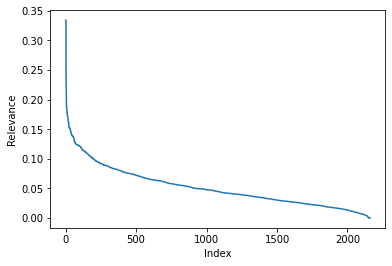

In [51]:
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs['Relevance'].values)
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.show()

Lower indices indicate higher relevance. The relevance is equal to the cosine similarity between each job and skills. This relevance drops rapidly at an index of approximately 60.

We will include a vertical cutoff of 60 is also included in the plot. Indices below 60 correspond to much higher relevance values.

Now we will visualize the shape of the sorted relevance distribution relative to rank.

### 5.7. Adding a cutoff to the relevance plot.

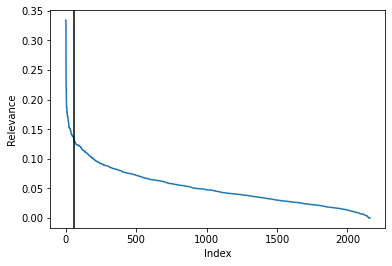

In [52]:
plt.plot(range(df_jobs.shape[0]), sorted_df_jobs['Relevance'].values)
plt.xlabel('Index')
plt.ylabel('Relevance')
plt.axvline(60, c='k')
plt.show()

As we’ve already seen, the first 20 jobs are highly relevant. Based on our hypothesis, jobs 40 through 60 should be highly relevant as well. Next, we print the title of sorted_ds_jobs[40: 60] for evaluation purposes.

In [53]:
for title in sorted_df_jobs[40: 60]['title'].values:
    print(title)

Data Scientist
Data Scientist
Sr. Data Scientist
Data Scientist
Data Scientist
Data Scientist
Data Scientist
Software Engineer – Data Scientists
Data Scientist
Data Scientist
Data Scientist
Data Scientist
Data Scientist
Data Scientist
Data Scientist
Data Scientist
Machine Learning Engineer
AI/ML - Data Engineer
Data Analyst
AI/ML Engineer


Almost all positions are for a Data Scientist Position

In [54]:
for title in sorted_df_jobs[60: 80]['title'].values:
    print(title)

Data Scientist
AI ENGINEER
AI ENGINEER
Engineer I - Machine Learning
Engineer I - Machine Learning
Engineer I - Machine Learning
Data Scientist
Data Scientist
Data Scientist
Data Scientist
Analytics Data engineer
AI Engineer
Lead Machine Learning Engineer/ Data Scientist (India)
NLP / Machine Learning
Data Scientist
Engineer | Machine Learning
Data Scientist/ Machine Learning Consultant ( UK Location)
Python Developer For Machine Learning
Python Developer For Machine Learning
Machine Learning Architect


A few of the job titles for postings 60 through 80 are noticeably less relevant. Some jobs are for AI Engineer or Machine Learning Engineer, and few are in consulting positions. Nonetheless, a majority of the jobs refer to data science roles. We can quickly quantify this observation using regular expressions. We define a percent_relevant_titles function, which returns the percent of other related jobs in a data frame slice. Then we apply that function to sorted_df_jobs[60: 80]. The output gives us a very simple alternative measure of relevance based on job post titles.

### 5.8. Measuring title relevance in a subset of jobs.

In [55]:
import re

In [56]:
def percent_relevant_titles(df):
    regex_relevant = re.compile(r'(Data|AI) (Scien|Analy|Engineer)', flags=re.IGNORECASE)
    # We ignore any management titles
    regex_irrelevant = re.compile(r'\b(Manage)', flags=re.IGNORECASE)
    match_count = len([title for title in df['title'] 
                       if regex_relevant.search(title) and not regex_irrelevant.search(title)])
    percent = 100 * match_count / df.shape[0]
    return percent

In [57]:
percent = percent_relevant_titles(sorted_df_jobs[60: 80])
print(f"Approximately {percent:.2f}% of job titles between indices 60 - 80 are relevant")

Approximately 60.00% of job titles between indices 60 - 80 are relevant


In [58]:
percent = percent_relevant_titles(sorted_df_jobs[80: 100])
print(f"Approximately {percent:.2f}% of job titles between indices 80 - 100 are relevant")

Approximately 15.00% of job titles between indices 80 - 100 are relevant


In [59]:
percent = percent_relevant_titles(sorted_df_jobs[100: 120])
print(f"Approximately {percent:.2f}% of job titles between indices 100 - 120 are relevant")

Approximately 70.00% of job titles between indices 100 - 120 are relevant


In [60]:
percent = percent_relevant_titles(sorted_df_jobs[120: 140])
print(f"Approximately {percent:.2f}% of job titles between indices 120 - 140 are relevant")

Approximately 25.00% of job titles between indices 120 - 140 are relevant


In [61]:
percent = percent_relevant_titles(sorted_df_jobs[140: 160])
print(f"Approximately {percent:.2f}% of job titles between indices 140 - 160 are relevant")

Approximately 65.00% of job titles between indices 140 - 160 are relevant


In [62]:
percent = percent_relevant_titles(sorted_df_jobs[160: 180])
print(f"Approximately {percent:.2f}% of job titles between indices 160 - 180 are relevant")

Approximately 85.00% of job titles between indices 160 - 180 are relevant


In [63]:
percent = percent_relevant_titles(sorted_df_jobs[180: 200])
print(f"Approximately {percent:.2f}% of job titles between indices 180 - 200 are relevant")

Approximately 80.00% of job titles between indices 180 - 200 are relevant


The percentages are all over the place.

So let us plot all the percentages in a graph and add a 50% relevant line to demarcate the mid center line.

### 5.9. Plotting percent relevance across all title samples.

In [64]:
def relevant_title_plot(index_range=20):
    percentages = []
    start_indices = range(df_jobs.shape[0] - index_range)
    for i in start_indices:
        df_slice = sorted_df_jobs[i: i + index_range]
        percent = percent_relevant_titles(df_slice)
        percentages.append(percent)
    plt.plot(start_indices, percentages)
    plt.axhline(50, c='k')
    plt.xlabel('Index')
    plt.ylabel('% Relevant Titles')

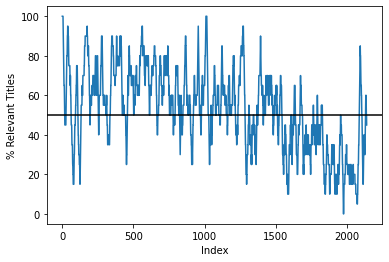

In [65]:
relevant_title_plot()
plt.show()

The plot fluctuates with a high degree of variance. But despite the fluctuations, we can observe that the relevant data science titles stays at a similar level.

We can observe that with a index_range of 80 and a index cutoff of 1500, the values are quite in a decreasing slope.

### 5.10. Plotting percent relevance across an increased index range.

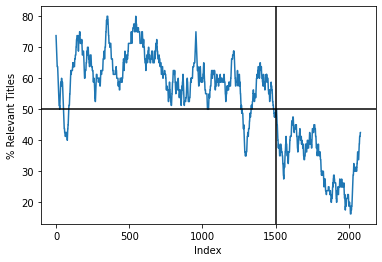

In [66]:
relevant_title_plot(index_range=80)
plt.axvline(1500, c='k')
plt.show()

At this point, we face a choice between two relevance cutoffs. Our first cutoff, at index 80, is highly precise: most jobs below that cutoff are data science positions. However, the cutoff has limited recall: hundreds of data science jobs appear beyond an index of 80. Meanwhile, our second cutoff of 1500 captures many more data science positions, but some irrelevant jobs also appear below the cutoff range. We will incorporate both cutoffs, that way, we can compare the trade-offs and benefits of each! First, we’ll cluster the skill sets from job postings below an index of 80 then, we’ll repeat our analysis for job postings below an index of 1500. Finally, we’ll integrate these two different analyses into a single, coherent conclusion.

## 6. Clustering skills in relevant job postings

Our stated aim is to identify missing skills. The bullet points focus more on individual skills than the heterogeneous body of each posting. The short bullet points are easy to print and read. This is not the case for the larger postings. Thus, clustering by bullets allows us to examine each cluster by outputting a sample of the clustered bullet text. We’ll cluster the scraped bullets. We start by storing sorted_df_jobs[:80]['Bullets'] in a single list.